install all required packages in your python environment
```sh
pip install scipy catboost shap seaborn
```
or create a separate conda env
```sh
conda create -n pdenv python==3.9 scipy catboost shap seaborn jupyter statsmodels
conda activate pdenv
```

download dataset
```sh
python download.py
```

In [1]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.inspection import partial_dependence
from scipy.interpolate import interp1d
import scipy.stats as stats
import matplotlib.pyplot as plt
import catboost
import shap
import seaborn as sns
sns.set_theme()


def load_data():
    df = pd.DataFrame(loadarff(os.path.join("data", "5year.arff"))[0])
    df["class"] = df["class"].astype("int")
    df.drop(columns=["Attr37", "Attr27", "Attr5", "Attr6", "Attr48", "Attr49"], inplace=True)
    imputer = KNNImputer()
    df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])
    return df


def make_sample_datasets(df, n=15, replace=True):
    return [df.sample(frac=1.0, replace=replace, random_state=i) for i in range(n)]


def make_split(df, val=False):
    X = df.iloc[:, :-1]
    y = df["class"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    if val:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1286, random_state=0, stratify=y_train)
        return X_train, X_test, X_val, y_train, y_test, y_val
    return X_train, X_test, y_train, y_test


def train(df, depth):
    X_train, X_test, X_val, y_train, y_test, y_val = make_split(df, val=True)
    cb_mod = catboost.CatBoostClassifier(
        depth=depth,
        iterations=1000,
        )
    cb_mod.fit(X_train, y_train, early_stopping_rounds=50, use_best_model=True, eval_set=(X_val, y_val), verbose=0)
    return cb_mod, X_test, y_test


def train_models(df, depth=2, n=15):
    return [train(df_boot, depth=depth) for df_boot in make_sample_datasets(df, n=n)]


def estimate_pdp(model_data_pairs, features):
    pdp_set = []
    for model, X_test, y_test in model_data_pairs:
        pdp = partial_dependence(
            model, 
            X_test, 
            features,
            response_method="predict_proba",
            method="brute",
            kind="mean",
        )
        pdp_set.append((pdp["values"][0], pdp["average"][0], y_test.mean()))

    return pdp_set


def interpolate(pdps):
    min_val = max(min(values) for values, _, _ in pdps)
    max_val = min(max(values) for values, _, _ in pdps)
    vals = np.linspace(min_val, max_val, 100)
    return (
        vals,
        np.array([interp1d(values, average)(vals) for values, average, mean_labels in pdps]),
        np.array([mean_labels for _, _, mean_labels in pdps])
        )


translate = {
    "Attr1": "net profit / total assets",
    "Attr1": "net profit / total assets",
    "Attr2": "total liabilities / total assdepthets",
    "Attr3": "working capital / total assets",
    "Attr4": "current assets / short-term liabilities",
    "Attr5": "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
    "Attr6": "retained earnings / total assets",
    "Attr7": "EBIT / total assets",
    "Attr8": "book value of equity / total liabilities",
    "Attr9": "sales / total assets",
    "Attr10": "equity / total assets",
    "Attr11": "(gross profit + extraordinary items + financial expenses) / total assets",
    "Attr12": "gross profit / short-term liabilities",
    "Attr13": "(gross profit + depreciation) / sales",
    "Attr14": "(gross profit + interest) / total assets",
    "Attr15": "(total liabilities * 365) / (gross profit + depreciation)",
    "Attr16": "(gross profit + depreciation) / total liabilities",
    "Attr17": "total assets / total liabilities",
    "Attr18": "gross profit / total assets",
    "Attr19": "gross profit / sales",
    "Attr20": "(inventory * 365) / sales",
    "Attr21": "sales (n) / sales (n-1)",
    "Attr22": "profit on operating activities / total assets",
    "Attr23": "net profit / sales",
    "Attr24": "gross profit (in 3 years) / total assets",
    "Attr25": "(equity - share capital) / total assets",
    "Attr26": "(net profit + depreciation) / total liabilities",
    "Attr27": "profit on operating activities / financial expenses",
    "Attr28": "working capital / fixed assets",
    "Attr29": "logarithm of total assets",
    "Attr30": "(total liabilities - cash) / sales",
    "Attr31": "(gross profit + interest) / sales",
    "Attr32": "(current liabilities * 365) / cost of products sold",
    "Attr33": "operating expenses / short-term liabilities",
    "Attr34": "operating expenses / total liabilities",
    "Attr35": "profit on sales / total assets",
    "Attr36": "total sales / total assets",
    "Attr37": "(current assets - inventories) / long-term liabilities",
    "Attr38": "constant capital / total assets",
    "Attr39": "profit on sales / sales",
    "Attr40": "(current assets - inventory - receivables) / short-term liabilities",
    "Attr41": "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
    "Attr42": "profit on operating activities / sales",
    "Attr43": "rotation receivables + inventory turnover in days",
    "Attr44": "(receivables * 365) / sales",
    "Attr45": "net profit / inventory",
    "Attr46": "(current assets - inventory) / short-term liabilities",
    "Attr47": "(inventory * 365) / cost of products sold",
    "Attr48": "EBITDA (profit on operating activities - depreciation) / total assets",
    "Attr49": "EBITDA (profit on operating activities - depreciation) / sales",
    "Attr50": "current assets / total liabilities",
    "Attr51": "short-term liabilities / total assets",
    "Attr52": "(short-term liabilities * 365) / cost of products sold)",
    "Attr53": "equity / fixed assets",
    "Attr54": "constant capital / fixed assets",
    "Attr55": "working capital",
    "Attr56": "(sales - cost of products sold) / sales",
    "Attr57": "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
    "Attr58": "total costs /total sales",
    "Attr59": "long-term liabilities / equity",
    "Attr60": "sales / inventory",
    "Attr61": "sales / receivables",
    "Attr62": "(short-term liabilities *365) / sales",
    "Attr63": "sales / short-term liabilities",
    "Attr64": "sales / fixed assets",
}

def plot_model_pdp(model, data, feature, conf_int=False):
    pdp = partial_dependence(
    model, 
    data, 
    [feature],
    response_method="predict_proba",
    method="brute",
    kind="mean",
    )
    values, mean = pdp["values"][0], pdp["average"][0]
    plt.plot(values, mean, "-", linewidth=2)
    if conf_int:
        stds = []
        correct_feature_vals = data[feature].copy()
        for val in values:
            data[feature] = val
            predicts = model.predict_proba(data)[:,1]
            std = (((predicts - predicts.mean())**2).sum() / predicts.shape[0] / (predicts.shape[0] - 1))**0.5
            stds.append(std)
        data[feature] = correct_feature_vals
        stds = np.array(stds)
        conf_interval = stats.t.ppf(0.975, df=stds.shape[0]-1) * stds
        
        plt.plot(values, mean-conf_interval, "--", linewidth=1, color="grey")
        plt.plot(values, mean+conf_interval, "--", linewidth=1, color="grey")
    plt.xlabel(f"{translate[feature]} ({feature})")
    plt.show()


def plot_pdp(model_data_pairs, feature):
    pdps = estimate_pdp(model_data_pairs, [feature])
    vals, pdps_i, mean_targets = interpolate(pdps)
    C = 0.3/0.7 # test_size/ train_size
    mean = pdps_i.mean(axis=0)
    std = (((pdps_i - mean)**2).sum(axis=0) * (1/(pdps_i.shape[0]-1)) * (1/pdps_i.shape[0] + C))**0.5
    conf_interval = std * stats.t.ppf(0.975, df=pdps_i.shape[1]-1)
    for average in pdps_i:
        plt.plot(vals, average, color="grey", alpha=0.2)
    plt.plot(vals, mean, "-", linewidth=2 )
    plt.plot(vals, mean-conf_interval, "--", linewidth=1, color="grey")
    plt.plot(vals, mean+conf_interval, "--", linewidth=1, color="grey")
    plt.xlabel(f"{translate[feature]} ({feature})")
    plt.show()


def plot_pdp_p(model_data_pairs, feature):
    pdps = estimate_pdp(model_data_pairs, [feature])
    vals, pdps_i, mean_targets = interpolate(pdps)
    C = 0.3/0.7 # test_size/ train_size
    pair_diff = pdps_i - mean_targets[:,np.newaxis]
    mean = pair_diff.mean(axis=0)
    std = (((pair_diff - mean)**2).sum(axis=0) * (1/(pair_diff.shape[0]-1)) * (1/pair_diff.shape[0] + C))**0.5
    t_stat = mean / std
    p = stats.t.cdf(-np.abs(t_stat), df=pair_diff.shape[0]-1)
    plt.plot(vals, p, linewidth=2, color="black")
    plt.xlabel(f"{translate[feature]} ({feature})")
    plt.show()


def shap_abs_mean(model, data):
    return np.abs(shap.TreeExplainer(model).shap_values(data)).mean(axis=0)


def shap_importance(model_data_pairs):
    means = [shap_abs_mean(model, data) for model, data, label in model_data_pairs]
    means = np.array(means)
    C = 0.3/0.7
    mean = means.mean(axis=0)
    std = (((means - mean)**2).sum(axis=0) * (1/(means.shape[0]-1)) * (1/means.shape[0] + C))**0.5
    conf_interval = std * stats.t.ppf(0.975, df=means.shape[1])
    cols = model_data_pairs[0][1].columns
    order = mean.argsort()[::-1]
    
    return mean[order], conf_interval[order], cols[order]


def plot_mean_abs_shap_conf(mean, conf_interval, cols, top=10):
    mean, conf_interval, cols = mean[:top], conf_interval[:top], cols[:top]
    for i, (val, interval, name) in enumerate(zip(mean, conf_interval, cols)):
        plt.plot((val-interval, val+interval),(top-i-1, top-i-1), "-", linewidth=2, color="grey")
        plt.plot((val,), (top-i-1,), "o", linewidth=5, color="black")

    plt.yticks(range(top), list(cols[::-1].map(lambda x: f"{translate[x]} ({x})")))

    plt.show()

In [2]:
df = load_data()
model_data_pairs_2 = train_models(df, depth=2)
# model_data_pairs_1 = train_models(df, depth=1)

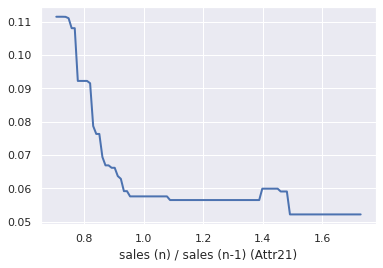

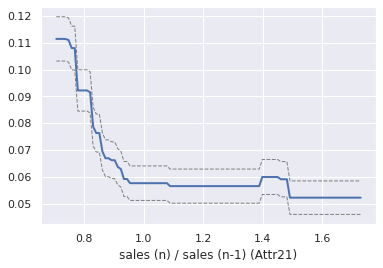

In [3]:
# partial depnedence plot examaple
model, data, _ = model_data_pairs_2[0]
feature = "Attr21"
plot_model_pdp(model, data, feature, conf_int=False)
plot_model_pdp(model, data, feature, conf_int=True)


In [4]:
# shap dependence plot example

shap_obj = shap.TreeExplainer(model)(data)

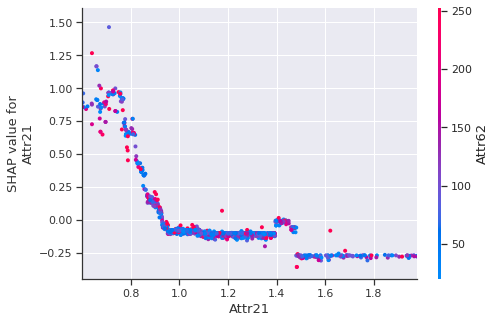

In [5]:
shap.dependence_plot("Attr21", shap_obj.values, data, xmax="percentile(97)", xmin="percentile(3)")

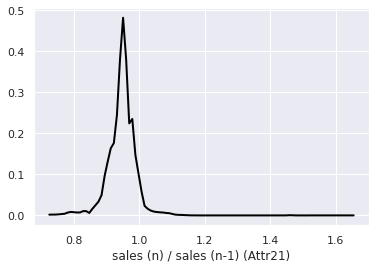

In [6]:
plot_pdp_p(model_data_pairs_2, "Attr21")

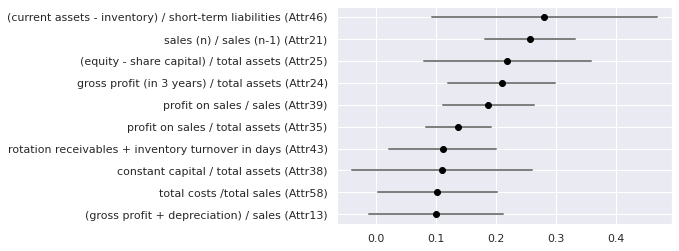

In [7]:
# global feature importance
# mean absolute Shapley valueas

res_2 = shap_importance(model_data_pairs_2)
plot_mean_abs_shap_conf(*res_2)

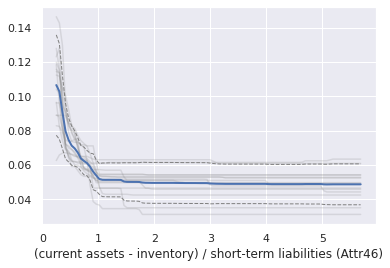

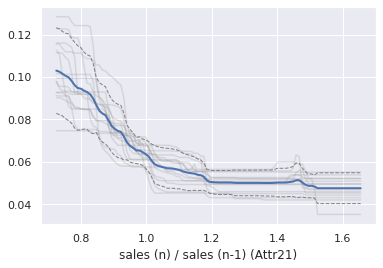

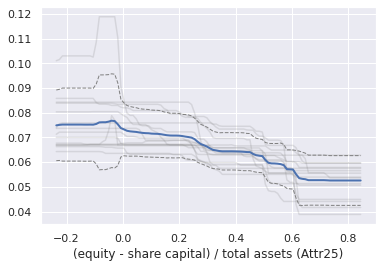

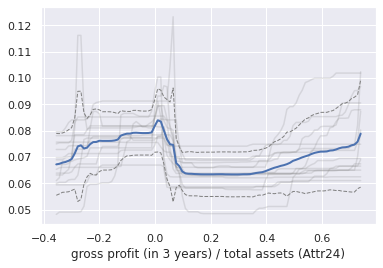

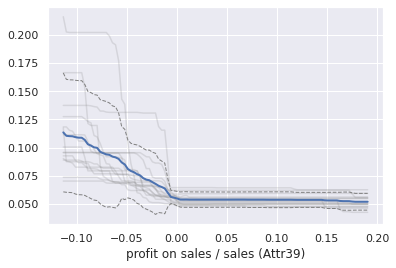

In [8]:
# PDP with bootstap CI
for feature in res_2[2][:5]:
    plot_pdp(model_data_pairs_2, feature) # 2

invalid value encountered in true_divide


average precision  0.1543364221217058
roc_auc_score  0.7467405764966741
ks_stat  0.4343237250554324


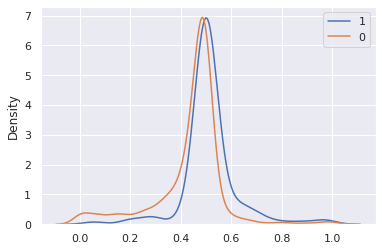

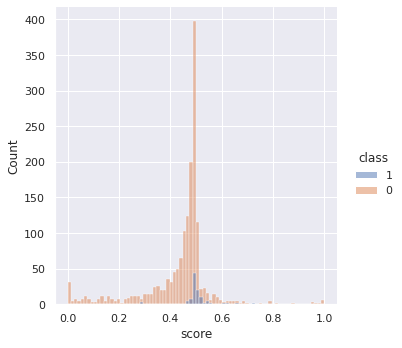

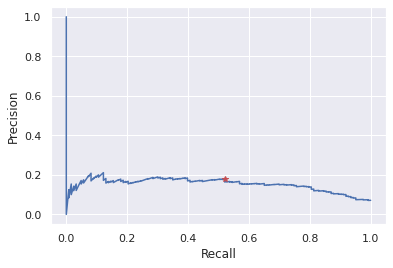

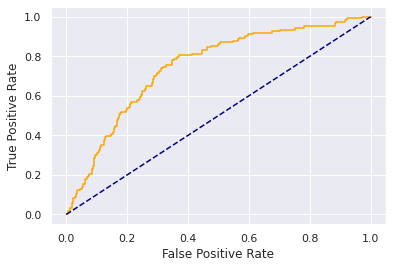

In [9]:
# naive logistic regression

from sklearn.linear_model import LogisticRegression
from score import score 

X_train, X_test, y_train, y_test = make_split(df)
lr_model = LogisticRegression(max_iter=10000, random_state=0, solver="saga", penalty="l1")
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict_proba(X_test)[:, 1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=None)

invalid value encountered in true_divide


average precision  0.2650097203733504
roc_auc_score  0.7706183789110619
ks_stat  0.4520768662232077


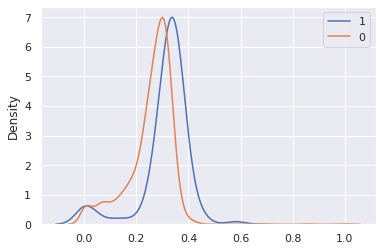

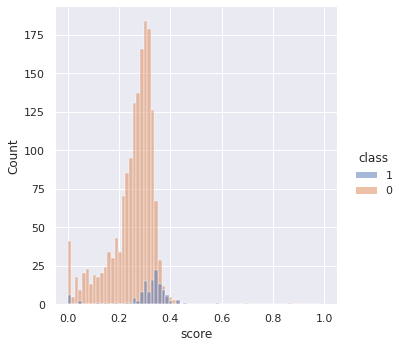

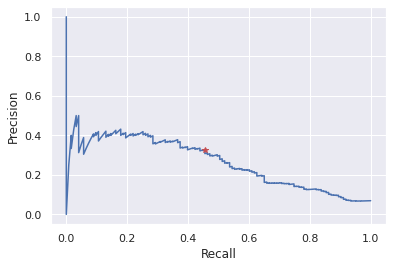

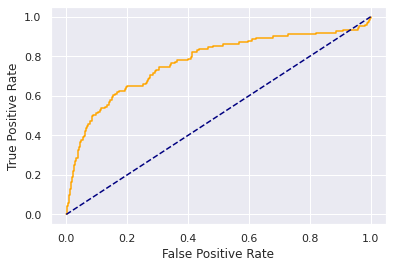

In [10]:
# LR with only 4 features

from sklearn.linear_model import LogisticRegression
from score import score 

X_train, X_test, y_train, y_test = make_split(df[["Attr21", "Attr46", "Attr25", "Attr39", "class"]])
lr_model = LogisticRegression(max_iter=10000, random_state=0, solver="saga", penalty="l1")
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict_proba(X_test)[:, 1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=None)

average precision  0.2660545604709272
roc_auc_score  0.824919931017492
ks_stat  0.5307021433850703


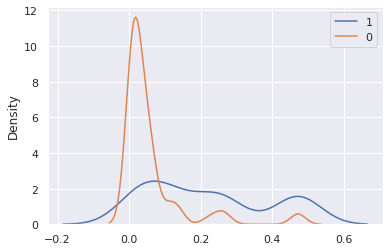

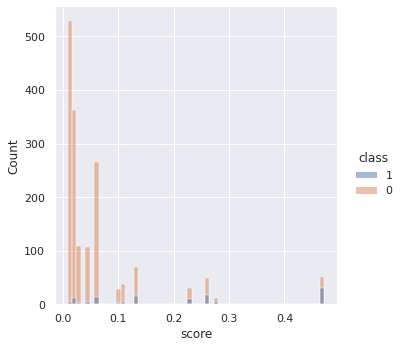

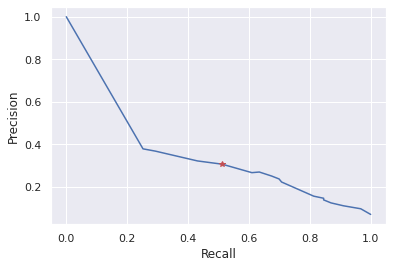

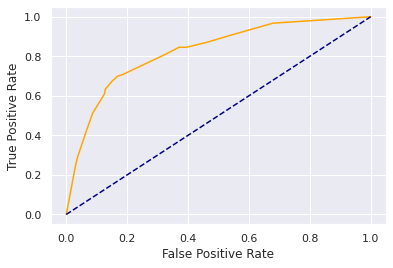

In [11]:
# LR with crafted binomial features
df_lr = pd.DataFrame({
    "Attr21": df["Attr21"]<1,
    "Attr46":df["Attr46"]<0.8,
    "Attr25": df["Attr25"]<0.4,
    "Attr39": df["Attr39"]<0, 
    "class": df["class"]
    })
df_lr = df_lr.astype("int8")

X_train, X_test, y_train, y_test = make_split(df_lr)
lr_model_ = LogisticRegression(max_iter=10000, random_state=0, solver="saga", penalty="l1")
lr_model_.fit(X_train, y_train)

y_pred = lr_model_.predict_proba(X_test)[:, 1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=None)

average precision  0.2992867279947208
roc_auc_score  0.8352352796255235
ks_stat  0.5592313377679231


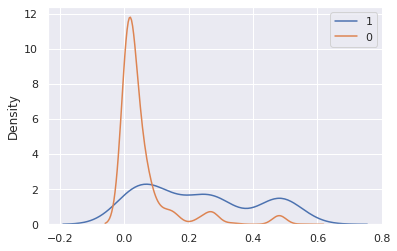

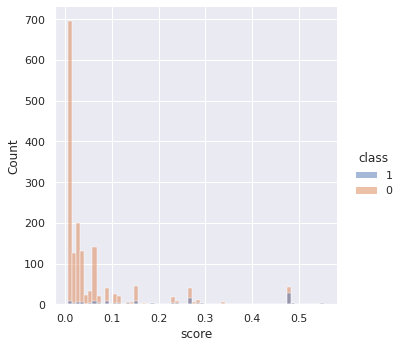

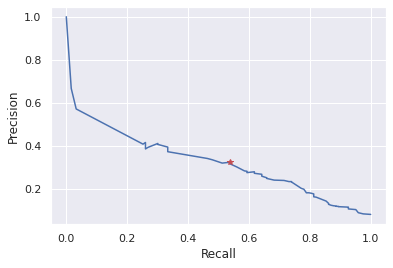

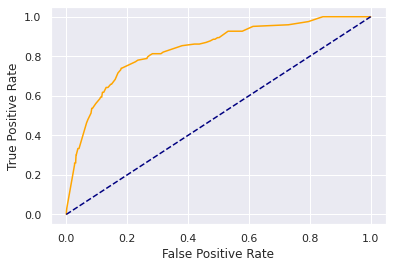

In [12]:
# LR with extra feature Attr24 bins included
df_lr_ = pd.DataFrame({
    "Attr21": df["Attr21"]<1,
    "Attr46":df["Attr46"]<0.8,
    "Attr25": df["Attr25"]<0.4,
    "Attr39": df["Attr39"]<0,
    "Attr24_less_0": df["Attr24"]<0, 
    "Attr24_00_01": (df["Attr24"]>=0) & (df["Attr24"]<0.1),
    "Attr24_great_04": df["Attr24"]>=0.4,
    "class": df["class"]
    })
df_lr_ = df_lr_.astype("int8")

X_train, X_test, y_train, y_test = make_split(df_lr_)
lr_model_1 = LogisticRegression(max_iter=10000, random_state=0, solver="saga", penalty="l1")
lr_model_1.fit(X_train, y_train)

y_pred = lr_model_1.predict_proba(X_test)[:, 1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=None)

In [2]:
# comparison with statsmodels implementation of LR

import statsmodels.api as sm
import statsmodels.formula.api as smf

ModuleNotFoundError: No module named 'statsmodels'

In [14]:
X_train, X_test, y_train, y_test = make_split(df_lr)
model_lr_stat = sm.Logit(
    y_train,
    sm.add_constant(X_train)
    ).fit()
print(model_lr_stat.summary())

Optimization terminated successfully.
         Current function value: 0.188032
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 4137
Model:                          Logit   Df Residuals:                     4132
Method:                           MLE   Df Model:                            4
Date:                Sat, 10 Sep 2022   Pseudo R-squ.:                  0.2539
Time:                        18:44:05   Log-Likelihood:                -777.89
converged:                       True   LL-Null:                       -1042.6
Covariance Type:            nonrobust   LLR p-value:                2.914e-113
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8175      0.177    -27.171      0.000      -5.165      -4.470
Attr21         0.9529      0.

In [15]:
X_train, X_test, y_train, y_test = make_split(df_lr_)

model_lr_stat = sm.Logit(
    y_train,
    sm.add_constant(X_train)
    ).fit()

Optimization terminated successfully.
         Current function value: 0.185590
         Iterations 8


In [16]:
print(model_lr_stat.summary())

                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 4137
Model:                          Logit   Df Residuals:                     4129
Method:                           MLE   Df Model:                            7
Date:                Sat, 10 Sep 2022   Pseudo R-squ.:                  0.2636
Time:                        18:44:05   Log-Likelihood:                -767.78
converged:                       True   LL-Null:                       -1042.6
Covariance Type:            nonrobust   LLR p-value:                1.707e-114
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.3597      0.232    -23.067      0.000      -5.815      -4.904
Attr21              0.9352      0.141      6.634      0.000       0.659       1.211
Attr46              1.1154      

average precision  0.30068327113547993
roc_auc_score  0.8331608770633161
ks_stat  0.5592313377679231


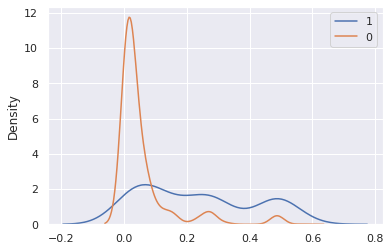

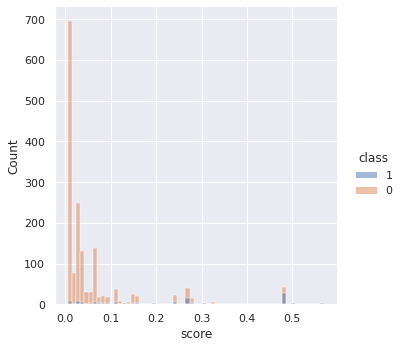

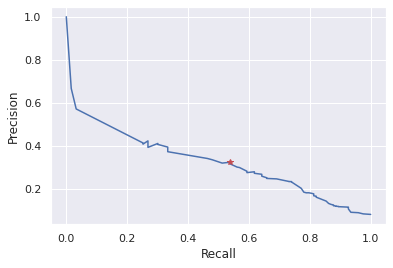

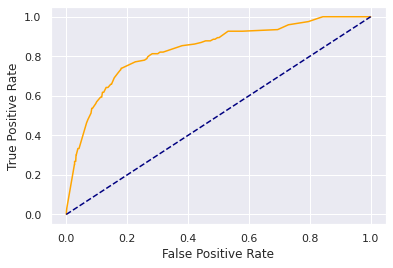

In [17]:
y_pred = model_lr_stat.predict(sm.add_constant(X_test))
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=None)

Learning rate set to 0.043495
0:	learn: 0.6337788	test: 0.6336207	best: 0.6336207 (0)	total: 1.76ms	remaining: 1.76s
100:	learn: 0.1633066	test: 0.1792327	best: 0.1791301 (93)	total: 174ms	remaining: 1.55s
200:	learn: 0.1528325	test: 0.1791346	best: 0.1780432 (161)	total: 367ms	remaining: 1.46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1780431578
bestIteration = 161

Shrink model to first 162 iterations.
average precision  0.4344545230678683
roc_auc_score  0.8683419561468342
ks_stat  0.6047893569844789


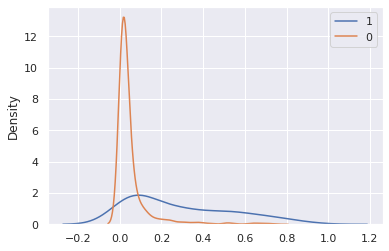

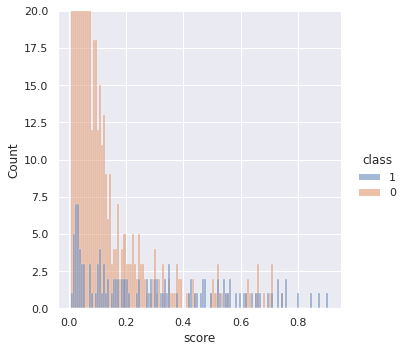

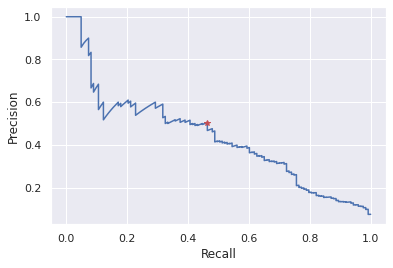

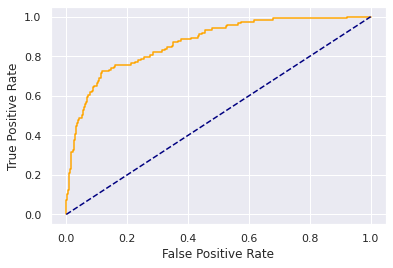

In [18]:
# Catbbost model performance based on top 5 important features

X_train, X_test, X_val, y_train, y_test, y_val = make_split(df[["Attr21", "Attr46", "Attr25", "Attr39", "Attr24", "class"]], val=True)

cb_mod_2 = catboost.CatBoostClassifier(depth=3, iterations=1000)
cb_mod_2.fit(X_train, y_train, early_stopping_rounds=50, use_best_model=True, eval_set=(X_val, y_val), verbose=100)

y_pred = cb_mod_2.predict_proba(X_test)[:,1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=20)

Learning rate set to 0.043495
0:	learn: 0.6288030	test: 0.6302187	best: 0.6302187 (0)	total: 8.81ms	remaining: 8.8s
100:	learn: 0.1423417	test: 0.1761002	best: 0.1758630 (98)	total: 391ms	remaining: 3.48s
200:	learn: 0.1176352	test: 0.1679191	best: 0.1679075 (199)	total: 924ms	remaining: 3.67s
300:	learn: 0.0962497	test: 0.1640831	best: 0.1639464 (293)	total: 1.46s	remaining: 3.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1639004345
bestIteration = 302

Shrink model to first 303 iterations.
average precision  0.42924046112709113
roc_auc_score  0.8766617393446662
ks_stat  0.6062527716186252


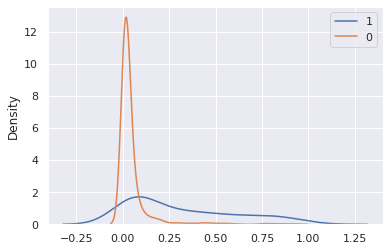

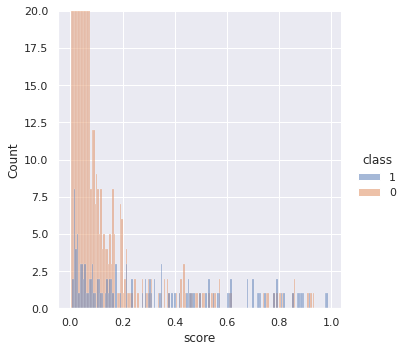

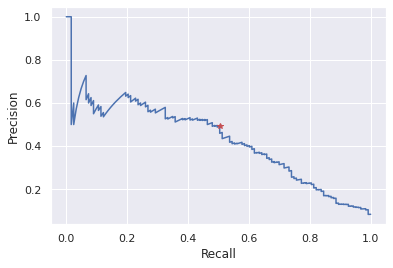

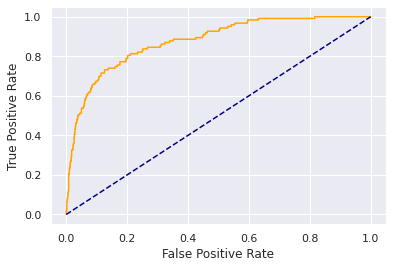

In [19]:
# Catboost performance based on all features

X_train, X_test, X_val, y_train, y_test, y_val = make_split(df, val=True)

cb_mod_1 = catboost.CatBoostClassifier(depth=4, iterations=1000)
cb_mod_1.fit(X_train, y_train, early_stopping_rounds=50, use_best_model=True, eval_set=(X_val, y_val), verbose=100)

y_pred = cb_mod_1.predict_proba(X_test)[:,1]
score(y_test=y_test, y_score=y_pred, show_plot=True, score_lim=20)